## Preparation

In [1]:
import geopandas as gpd
import pandas as pd
import os
import datetime
import numpy as np

In [2]:
# read inputs from spreadsheet
working_dr = os.getcwd()
data_dr = os.path.join(working_dr, 'data')
inputs_dr = os.path.join(working_dr, 'inputs.csv')
inputs_df = pd.read_csv(inputs_dr)

In [10]:
# choose a season
# by index
index = 0
row = inputs_df.iloc[index]
# # by name
# name = '2020_2021_wheat'
# row = inputs_df.loc[inputs_df['season'] == name].iloc[0]
season = row['season']
project_area_dr = row['project_area']
field_area_dr = row['field_area']
start_date = row['start_date']
end_date = row['end_date']
project_gdf = gpd.read_file(project_area_dr) #read shapefile
field_gdf = gpd.read_file(field_area_dr) #read shapefile
bbox_field = field_gdf.total_bounds.tolist()
bbox = project_gdf.total_bounds.tolist()

In [4]:
shp_name = os.path.basename(project_area_dr).split('.')[0]
project_dr = os.path.join(working_dr, 'data', shp_name)
season_dr = os.path.join(working_dr, 'data', shp_name, f'season_{season}')

## charts

In [ ]:
from funcs.charts import daily_chart

In [ ]:
daily_chart(season_dr, "ETa", 'avarage Daily ETa mm day')
daily_chart(season_dr, "biomass", 'avarage Daily biomass ton m3') ### check unit

## Images layouts

In [8]:
from funcs.layout import Layouts
layouts = Layouts()

In [27]:
for index, row in field_gdf.iterrows():
  print(field_gdf.iloc[[index]].total_bounds.tolist())

[238214.1364572446, 2090583.8078170386, 238782.29459364963, 2091180.7049056229]
[237453.14397798275, 2090464.5986139085, 237979.75953506026, 2091017.8471615324]
[236772.78891063435, 2088273.279006791, 237338.06586601317, 2088867.0735986307]
[237143.58682480676, 2092147.3127534497, 237681.62832240743, 2092712.6170328786]


In [15]:
project_gdf

,fid,id,geometry
0,1,0,"MULTIPOLYGON (((236138.022 2086915.201, 236238..."


In [ ]:
ex_bbox = _gdf.iloc[[index]].total_bounds.tolist()

In [13]:
bbox_field


[30.501554799811043, 18.869791577425698, 30.520308069557903, 18.90992127200704]

In [14]:
xmin, ymin, xmax, ymax = bbox_field
x_ticks = xmax-xmin
y_ticks = ymax-ymin         ### check
y_tick1,y_tick2,y_tick3 = ymin + y_ticks*2/8, ymin + y_ticks*4/8, ymin + y_ticks*6/8
x_tick1,x_tick2,x_tick3 = xmin + x_ticks*2/8, xmin + x_ticks*4/8, xmin + x_ticks*6/8

In [19]:
# x_tick1,x_tick2,x_tick3
# (f"{y_tick1:.2f}",f"{y_tick2:.2f}",f"{y_tick3:.2f}")
(f"{x_tick1:.2f}",f"{x_tick2:.2f}",f"{x_tick3:.2f}")

('30.51', '30.51', '30.52')

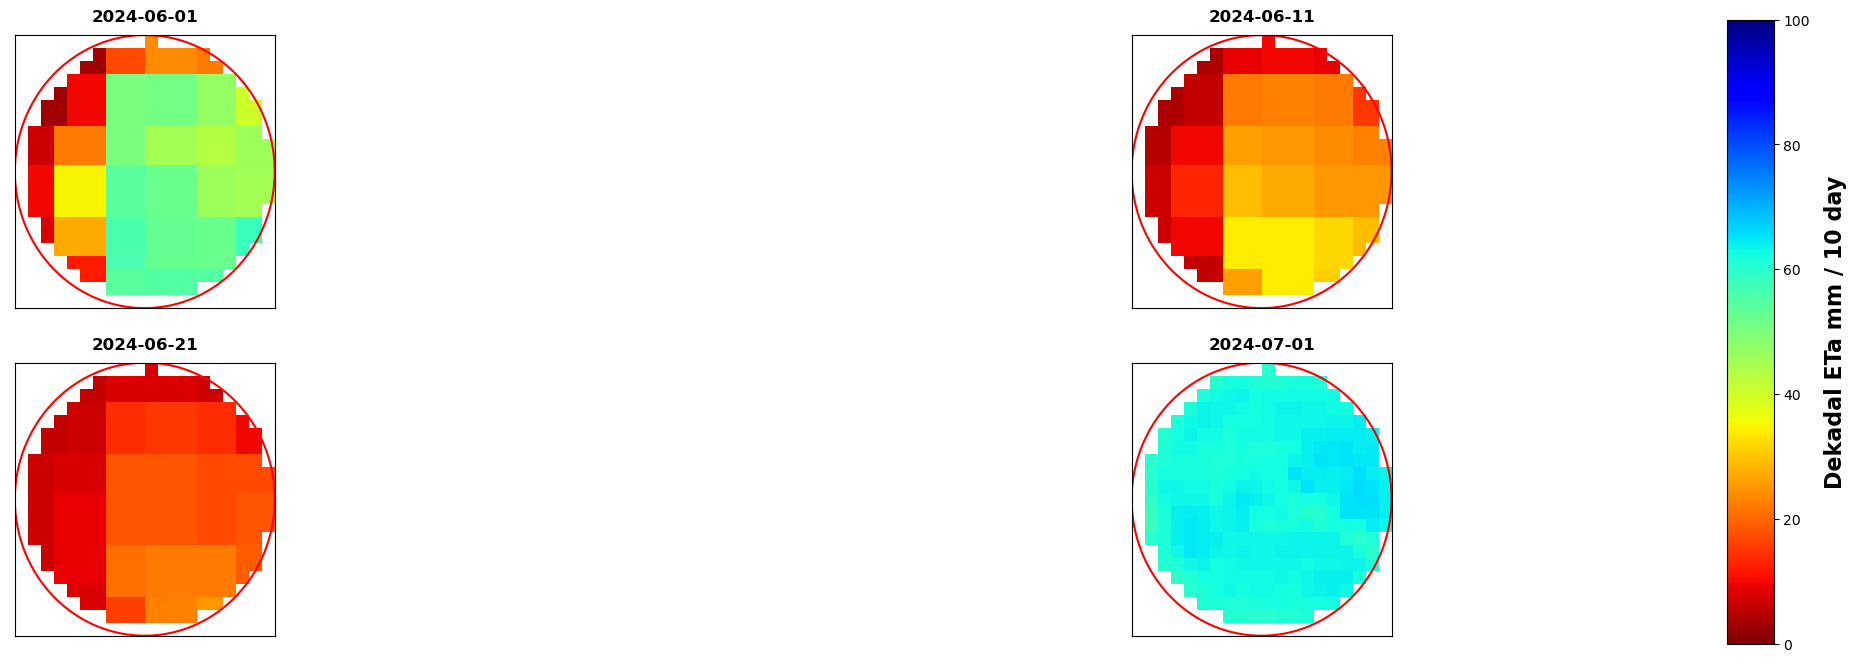

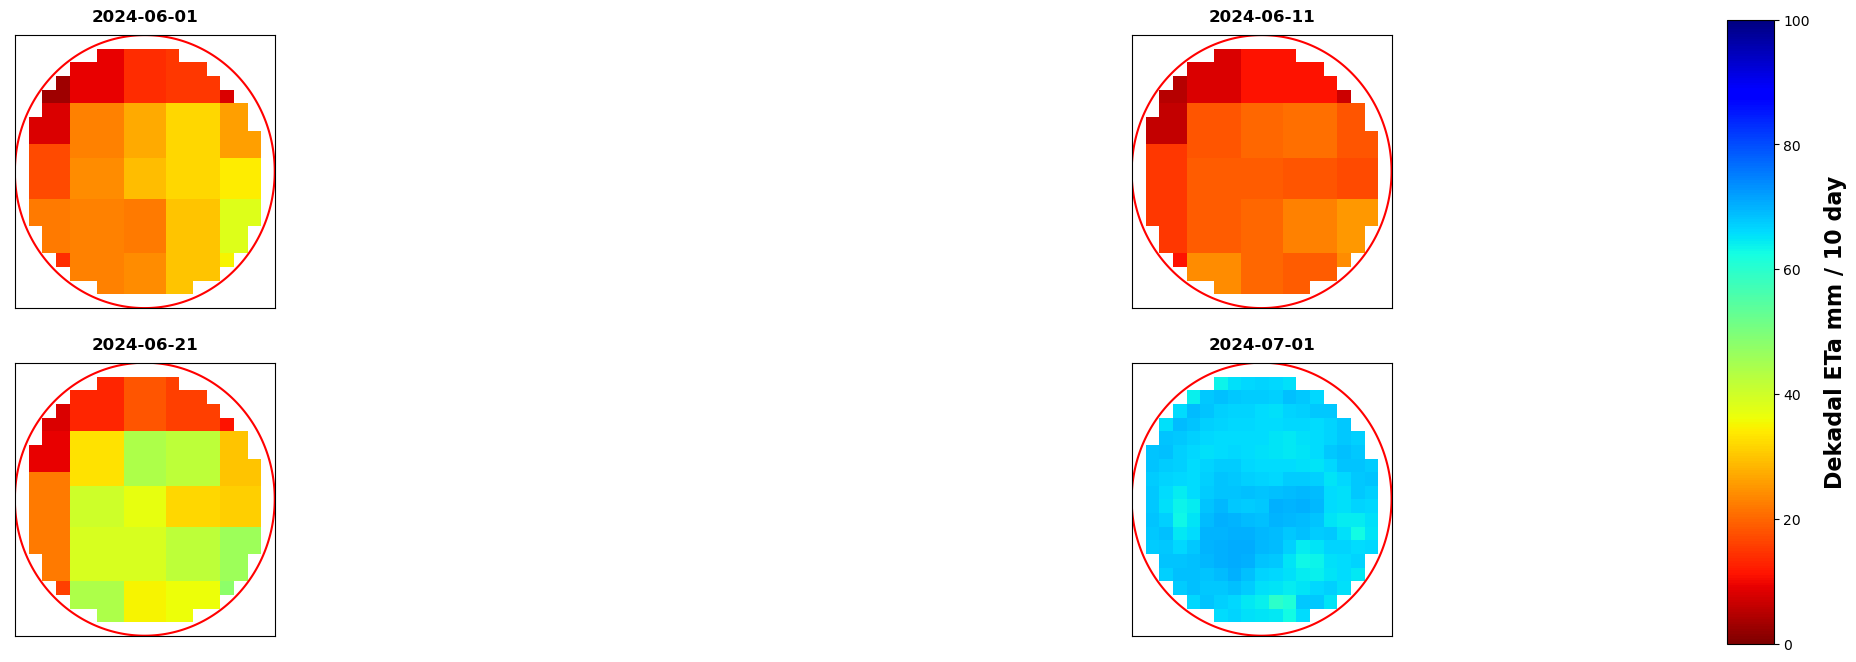

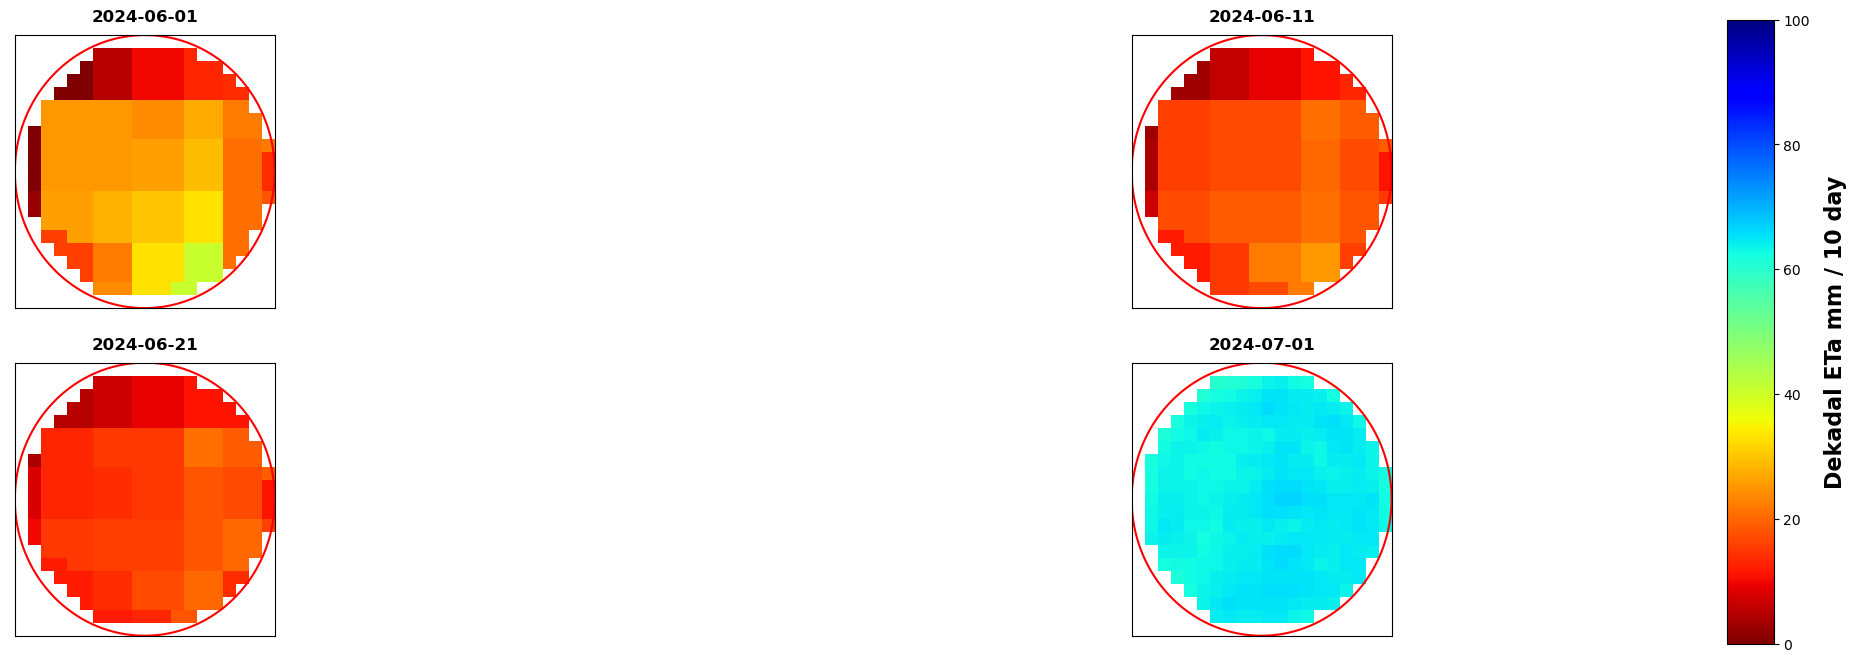

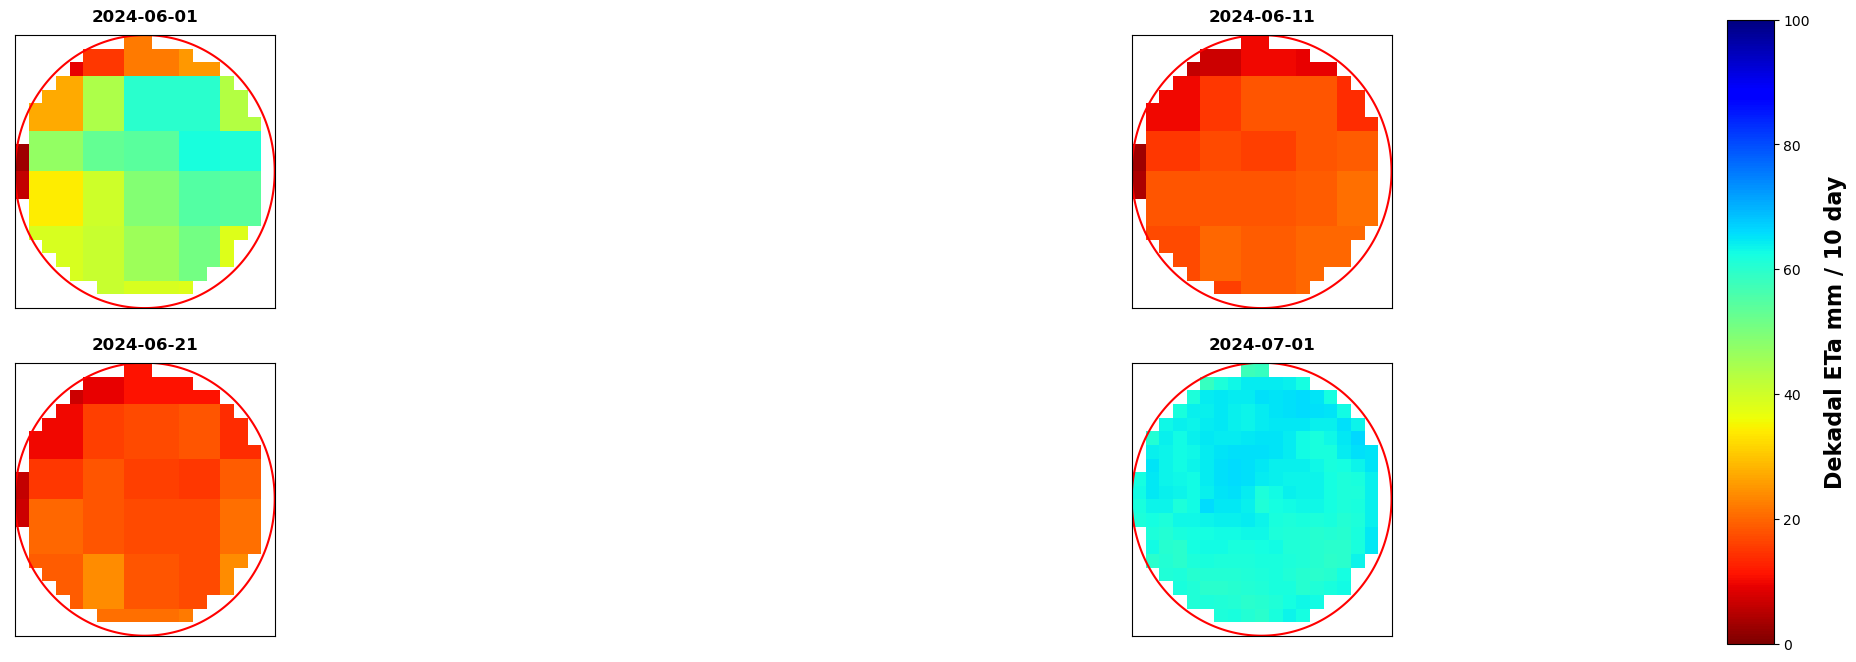

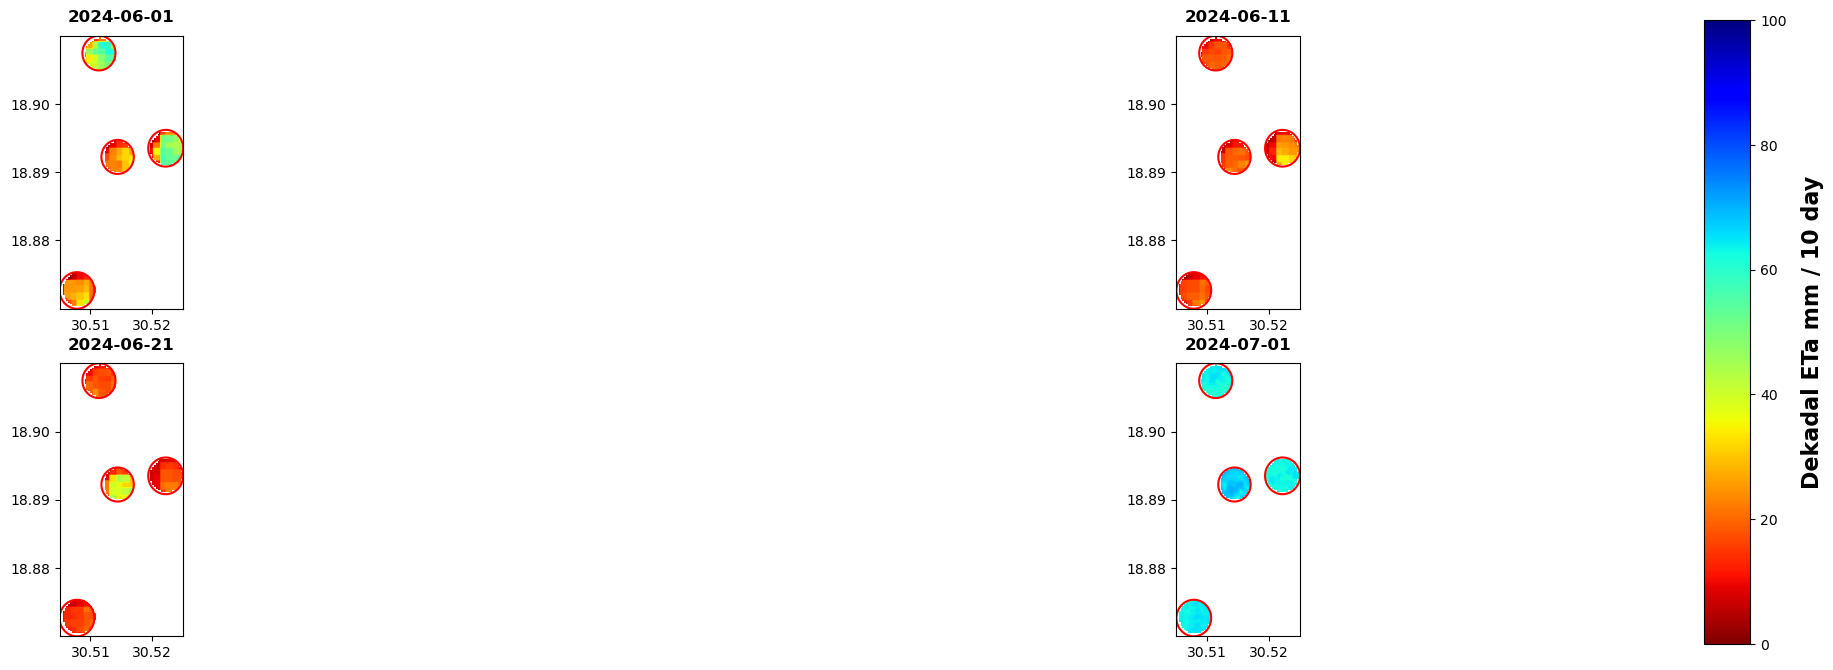

In [40]:
# days ETa layout
layouts = Layouts()
template = glob.glob(os.path.join(season_dr, 'dekads', "2024-07-01", "ETa", "tifs")+"/*.tif")[0]
dekads = sorted(os.listdir(os.path.join(season_dr, 'dekads')))
src = rasterio.open(template)
field_gdf = field_gdf.to_crs(src.crs)
project_gdf = project_gdf.to_crs(src.crs)

layouts.days_images_layout_fields(season_dr, dekads, field_gdf, bbox, False, 'Dekadal ETa mm / 10 day', 'ETa', 0, 100, True)
layouts.days_images_layout_all(season_dr, dekads, field_gdf, bbox_field, True, 'Dekadal ETa mm / 10 day', 'ETa', 0, 100, True)

In [6]:
import os
import glob
import rasterio
import rasterio.mask
import numpy as np
import matplotlib.pyplot as plt

In [38]:
class Layouts():
  def __init__(self):
    self.cmaps = {
      'ETa': 'jet_r',
      'biomass': 'Greens',
    }

  def set_ticks(self, axe, bbox):
    yb,ye = axe.get_ylim()
    xb,xe = axe.get_xlim()
    y = ye - yb
    x = xe - xb
    y1,y2,y3 = yb + y*2/8, yb + y*4/8, yb + y*6/8
    x1,x2,x3 = xb + x*2/8, xb + x*4/8, xb + x*6/8
    xmin, ymin, xmax, ymax = bbox
    x_ticks = xmax-xmin
    y_ticks = ymax-ymin         ### check
    y_tick1,y_tick2,y_tick3 = ymin + y_ticks*2/8, ymin + y_ticks*4/8, ymin + y_ticks*6/8
    x_tick1,x_tick2,x_tick3 = xmin + x_ticks*2/8, xmin + x_ticks*4/8, xmin + x_ticks*6/8
    ylabels = (f"{y_tick1:.2f}",f"{y_tick2:.2f}",f"{y_tick3:.2f}")
    # xlabels = (f"{x_tick1:.2f}",f"{x_tick2:.2f}",f"{x_tick3:.2f}")
    xlabels = (f"{x_tick1:.2f}",f"{x_tick3:.2f}")
    # axe.set_yticks([y1,y2,y3])
    # axe.set_yticks([x1,x2,x3])
    axe.set_yticks([y1,y2,y3],labels=ylabels)
    axe.set_xticks([x1,x3],labels=xlabels)
    # axe.set_yticks([y1,y2,y3],[f"{y1:.2f}",f"{y2:.2f}",f"{y3:.2f}"])
    # axe.set_xticks([x1,x2,x3],[f"{x1:.2f}",f"{x2:.2f}",f"{x3:.2f}"])


  def days_images_layout_fields(self, season_dr, dekads, field_gdf, bbox, set_ticks, layout_name, data, d_min, d_max, colorbar):
    tifs_paths = []
    for dekad in dekads:
      tif_path = os.path.join(season_dr, "dekads", dekad, data, f"{dekad}.tif")
      tifs_paths.append(tif_path)
    os.makedirs(os.path.join(season_dr, 'maps'), exist_ok= True)  # export_folder
    
    for index, field_row in field_gdf.iterrows():
      ex_bbox = field_gdf.iloc[[index]].total_bounds.tolist()
      spatial_extent = (ex_bbox[0], ex_bbox[2], ex_bbox[1], ex_bbox[3])
      # plot the images
      if len(tifs_paths) > 3:
          rows = 2
          cols = -(-len(tifs_paths) // rows)
          fig, axes = plt.subplots(rows, cols, figsize = (23.4,7.8), facecolor='white')
      else:
          rows = 1
          cols = len(tifs_paths)
          fig, axes = plt.subplots(rows, cols, figsize = (23.4,7.8), facecolor='white')
      for idx, tif_path in enumerate(tifs_paths):
          row = idx // cols
          col = idx % cols
          file_name = os.path.basename(tif_path).split('.')[0]
          with rasterio.open(tif_path) as src:
              tif_array = rasterio.mask.mask(src, [field_row.geometry], crop = True, nodata= np.nan)[0][0]
          if rows > 1:
            axes[row,col].set_title(file_name, fontweight= 'bold', pad = 10)
            # axes[row,col].imshow(tif_array, cmap = self.cmaps[data], vmin = d_min, vmax = d_max)
            axes[row,col].imshow(tif_array, cmap = self.cmaps[data], extent= spatial_extent, vmin = d_min, vmax = d_max)
            field_gdf.iloc[[index]].boundary.plot(ax= axes[row,col], color= 'red',)
            if set_ticks:
                self.set_ticks(axes[row,col], bbox)
            else:
                axes[row,col].set_xticks([])
                axes[row,col].set_yticks([])
          else:
            axes[col].set_title(file_name, fontweight= 'bold', pad = 10)
            # axes[col].imshow(tif_array, cmap = self.cmaps[data], vmin = d_min, vmax = d_max)
            axes[col].imshow(tif_array, cmap = self.cmaps[data], extent= spatial_extent, vmin = d_min, vmax = d_max)
            field_gdf.iloc[[index]].boundary.plot(ax= axes[col], color= 'red',)
            if set_ticks:
                self.set_ticks(axes[col], bbox)
            else:
                axes[col].set_xticks([])
                axes[col].set_yticks([])
      for i in range(len(tifs_paths), cols*rows):
          axes[i//cols, i%cols].set_visible(False)
      # set colot bar
      if colorbar:
          plt.subplots_adjust(right= 1)
          cax = fig.add_axes([1, 0.1, 0.02, 0.8])
          sm = plt.cm.ScalarMappable(cmap= self.cmaps[data])
          sm.set_array([d_min, d_max])
          plt.colorbar(
              sm,cax=cax, shrink=0.75, aspect=50,
              )
          cax.set_ylabel(layout_name, fontsize= 16, labelpad = 10, fontweight= 'bold')
      plt.savefig(os.path.join(season_dr, 'maps', f'{field_row.id}.png'), bbox_inches = 'tight', pad_inches = 0.1)

  def days_images_layout_all(self, season_dr, dekads, field_gdf, bbox, set_ticks, layout_name, data, d_min, d_max, colorbar):
    tifs_paths = []
    for dekad in dekads:
      tif_path = os.path.join(season_dr, "dekads", dekad, data, f"{dekad}.tif")
      tifs_paths.append(tif_path)
    os.makedirs(os.path.join(season_dr, 'maps'), exist_ok= True)  # export_folder
    ex_bbox = field_gdf.total_bounds.tolist()
    spatial_extent = (ex_bbox[0], ex_bbox[2], ex_bbox[1], ex_bbox[3])
    # plot the images
    if len(tifs_paths) > 3:
        rows = 2
        cols = -(-len(tifs_paths) // rows)
        fig, axes = plt.subplots(rows, cols, figsize = (23.4,7.8), facecolor='white')
    else:
        rows = 1
        cols = len(tifs_paths)
        fig, axes = plt.subplots(rows, cols, figsize = (23.4,7.8), facecolor='white')
    for idx, tif_path in enumerate(tifs_paths):
        row = idx // cols
        col = idx % cols
        file_name = os.path.basename(tif_path).split('.')[0]
        with rasterio.open(tif_path) as src:
            tif_array = rasterio.mask.mask(src, field_gdf.geometry, crop = True, nodata= np.nan)[0][0]
        if rows > 1:
            axes[row,col].set_title(file_name, fontweight= 'bold', pad = 10)
            # axes[row,col].imshow(tif_array, cmap = self.cmaps[data], vmin = d_min, vmax = d_max)
            axes[row,col].imshow(tif_array, cmap = self.cmaps[data], extent= spatial_extent, vmin = d_min, vmax = d_max)
            field_gdf.boundary.plot(ax= axes[row,col], color= 'red',)
            if set_ticks:
                self.set_ticks(axes[row,col], bbox)
            else:
                axes[row,col].set_xticks([])
                axes[row,col].set_yticks([])
        else:
            axes[col].set_title(file_name, fontweight= 'bold', pad = 10)
            # axes[col].imshow(tif_array, cmap = self.cmaps[data], vmin = d_min, vmax = d_max)
            axes[col].imshow(tif_array, cmap = self.cmaps[data], extent= spatial_extent, vmin = d_min, vmax = d_max)
            field_gdf.boundary.plot(ax= axes[col], color= 'red',)
            if set_ticks:
                self.set_ticks(axes[col], bbox)
            else:
                axes[col].set_xticks([])
                axes[col].set_yticks([])
    for i in range(len(tifs_paths), cols*rows):
        axes[i//cols, i%cols].set_visible(False)
    # set colot bar
    if colorbar:
        plt.subplots_adjust(right= 1)
        cax = fig.add_axes([1, 0.1, 0.02, 0.8])
        sm = plt.cm.ScalarMappable(cmap= self.cmaps[data])
        sm.set_array([d_min, d_max])
        plt.colorbar(
            sm,cax=cax, shrink=0.75, aspect=50,
            )
        cax.set_ylabel(layout_name, fontsize= 16, labelpad = 10, fontweight= 'bold')
    plt.savefig(os.path.join(season_dr, 'maps', f'all.png'), bbox_inches = 'tight', pad_inches = 0.1)


  def season_layout(self, tif_folder, data, label, exp_folder, bbox, field_shp, layout_name, m_max, s_max):
      tif_paths_month = sorted(glob.glob(os.path.join(tif_folder, f'{data}_month')+ "/*.tif"))
      tif_path_season = sorted(glob.glob(os.path.join(tif_folder, f'{data}_season')+ "/*.tif"))[0]
      spatial_extent = (bbox[0], bbox[2], bbox[1], bbox[3])
      # plot months images
      if len(tif_paths_month) > 3:
          rows = 2
          cols = -(-len(tif_paths_month) // rows)
          fig, axes = plt.subplots(rows, cols+1, figsize = (23.4,7.8), layout= 'constrained', facecolor='white')
          gs = axes[0,-1].get_gridspec()
      else:
          rows = 1
          cols = len(tif_paths_month)
          fig, axes = plt.subplots(rows, cols+1, figsize = (23.4,7.8), layout= 'constrained', facecolor='white')
          gs = axes[-1].get_gridspec()
      for idx, tif_path in enumerate(tif_paths_month):
          row = idx // cols
          col = idx % cols
          file_name = os.path.basename(tif_path).split('.')[0]
          with rasterio.open(tif_path) as src:
              tif_array = rasterio.mask.mask(src, field_shp.to_crs(src.crs).geometry, crop = True, nodata= np.nan)[0][0]
          if rows > 1:
              axes[row,col].set_title(file_name, fontweight= 'bold', pad = 10)
              axes[row,col].imshow(tif_array, cmap = self.cmaps[data], vmin = 0, vmax = m_max, extent= spatial_extent)
              self.set_ticks(axes[row,col], bbox)
          else:
              axes[col].set_title(file_name, fontweight= 'bold', pad = 10)
              axes[col].imshow(tif_array, cmap = self.cmaps[data], vmin = 0, vmax = m_max, extent= spatial_extent)
              self.set_ticks(axes[col], bbox)
      for i in range(len(tif_paths_month), cols*rows):
          axes[i//cols, i%cols].set_visible(False)

      # plot month images color bar and marge the last column into one ax
      if len(tif_paths_month) > 3:
          sm = plt.cm.ScalarMappable(cmap= self.cmaps[data])
          sm.set_array([0,m_max])
          fig.colorbar(sm, ax= axes[-1,:-1], label= f"{label}/month", shrink = 0.6, pad= 0.1, orientation= 'horizontal', aspect= 50)
          for ax in axes[0:, -1]:
              ax.remove()
          ax_big = fig.add_subplot(gs[0:, -1])
      else:
          sm = plt.cm.ScalarMappable(cmap= self.cmaps[data])
          sm.set_array([0,m_max])
          fig.colorbar(sm,ax= axes[:-1], label= f"{label}/month", shrink = 0.6, pad= 0.1, orientation= 'horizontal', aspect= 50)
          axes[-1].remove()
          ax_big = fig.add_subplot(gs[-1])

      # plot season image
      file_name = os.path.basename(tif_path_season).split('.')[0]
      with rasterio.open(tif_path_season) as src:
          tif_array = rasterio.mask.mask(src, field_shp.to_crs(src.crs).geometry, crop = True, nodata= np.nan)[0][0]
      ax_big.imshow(tif_array, cmap = self.cmaps[data], vmin = 0, vmax = s_max, extent= spatial_extent)
      ax_big.set_title(file_name, fontweight= 'bold', pad = 10)
      self.set_ticks(ax_big)
      # season image color bar
      sm = plt.cm.ScalarMappable(cmap= self.cmaps[data])
      sm.set_array([0,s_max])
      fig.colorbar(sm,ax= ax_big, label= f"{label}/season", shrink = 0.8, pad= 0.1)

      # export layout
      os.makedirs(exp_folder, exist_ok= True)
      plt.savefig(os.path.join(exp_folder, f'{layout_name}.png'), bbox_inches = 'tight', pad_inches = 0.1)